In [1]:
pwd

'd:\\Users\\jwangiy\\OneDrive - HKUST Connect\\23Fall\\MAFM6010Z_AI for Fintech\\warmup'

In [2]:
import os
for dirname, _, filenames in os.walk('./home-credit-default-risk'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./home-credit-default-risk\application_test.csv
./home-credit-default-risk\application_train.csv
./home-credit-default-risk\bureau.csv
./home-credit-default-risk\bureau_balance.csv
./home-credit-default-risk\credit_card_balance.csv
./home-credit-default-risk\HomeCredit_columns_description.csv
./home-credit-default-risk\installments_payments.csv
./home-credit-default-risk\POS_CASH_balance.csv
./home-credit-default-risk\previous_application.csv
./home-credit-default-risk\sample_submission.csv


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.reset_option("display.max_columns", 200)
pd.reset_option("display.max_rows", 200)

from tqdm import tqdm

In [4]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

In [5]:
import os
import torch
cpuCount = os.cpu_count()
print("CPU:", cpuCount)
print('GPU：', torch.cuda.device_count())


CPU: 12
GPU： 0


In [6]:
applytrain = pd.read_csv("./home-credit-default-risk/application_train.csv")
applytest = pd.read_csv("./home-credit-default-risk/application_test.csv")

In [7]:
features = pd.read_csv("./output/features.csv", index_col=0)

c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [12]:
features.head().T

,0,1,2,3,4
SK_ID_CURR,100002,100003,100004,100006,100007
CNT_CHILDREN,0,0,0,0,0
AMT_INCOME_TOTAL,202500.0,270000.0,67500.0,135000.0,121500.0
AMT_CREDIT,406597.5,1293502.5,135000.0,312682.5,513000.0
AMT_ANNUITY,24700.5,35698.5,6750.0,29686.5,21865.5
...,...,...,...,...,...
ORGANIZATION_TYPE,NaN,NaN,NaN,NaN,NaN
FONDKAPREMONT_MODE,NaN,NaN,NaN,NaN,NaN
HOUSETYPE_MODE,NaN,NaN,NaN,NaN,NaN
WALLSMATERIAL_MODE,NaN,NaN,NaN,NaN,NaN


In [13]:
missing_dict = {}
for col in tqdm(features.columns):
    missing_dict[col] = features[col].isnull().sum() / features.shape[0]

100%|██████████| 769/769 [00:00<00:00, 1216.13it/s]


#### delete those features whose missing rate over 90\%

In [14]:
feacols = [col for col in missing_dict.keys() if missing_dict[col] <= 0.9]
feacols.remove('SK_ID_CURR')

In [15]:
print(f'删除前的特征数量:{len(missing_dict.keys()) - 1}')
print(f'删除后的特征数量:{len(feacols)}')

删除前的特征数量:768
删除后的特征数量:753


#### 分成train和test

In [16]:
print(features.shape[0], applytrain.shape[0]+applytest.shape[0])
features = pd.merge(features, applytrain[['SK_ID_CURR', 'TARGET']], how='left', left_on=['SK_ID_CURR'], right_on=['SK_ID_CURR'])
print(features.shape)

356255 356255
(356255, 770)


In [17]:
features['TARGET'].value_counts(dropna=False)

0.0    282686
NaN     48744
1.0     24825
Name: TARGET, dtype: int64

In [18]:
applytest.shape
## check over

(48744, 121)

In [19]:
del applytrain
del applytest

In [20]:
strcols = []
for col in tqdm(feacols):
    if features[col].dtypes not in ['int64', 'float64']:
        try:
            features[col] = pd.to_numeric(features[col])
        except Exception as e:
            print(col)
            strcols.append(col)

100%|██████████| 753/753 [00:00<00:00, 3617.03it/s]

NAME_CONTRACT_TYPE
CODE_GENDER
FLAG_OWN_CAR
FLAG_OWN_REALTY
NAME_TYPE_SUITE
NAME_INCOME_TYPE
NAME_EDUCATION_TYPE
NAME_FAMILY_STATUS
NAME_HOUSING_TYPE
WEEKDAY_APPR_PROCESS_START
ORGANIZATION_TYPE


In [21]:
feacols = [col for col in feacols if col not in strcols]

In [22]:
def replace_nm(s, str1, str2):
    for string in str1:
        s = s.replace(string, str2)
    return s
replace_nm('abc', ['a', 'b'], '_')

'__c'

In [23]:
features.rename(columns={col:replace_nm(col, ['(', ')', '.'], '_') for col in features.columns}, inplace=True)
feacols = [replace_nm(col, ['(', ')', '.'], '_') for col in feacols]

In [24]:
X = features[(features['TARGET'].isnull() == False)]
test = features[(features['TARGET'].isnull() == True)]
print(X.shape, test.shape)

(307511, 770) (48744, 770)


### choosing features

In [33]:
X['TARGET'].value_counts(normalize=True)

0.0    0.919271
1.0    0.080729
Name: TARGET, dtype: float64

In [34]:
X['TARGET'].value_counts(normalize=False)

0.0    282686
1.0     24825
Name: TARGET, dtype: int64

In [27]:
from sklearn.model_selection import train_test_split

# train:test:dev = 8:1:1
X_train, X_test, y_train, y_test = train_test_split(X[feacols], X['TARGET'], test_size=0.2, random_state=42)
X_test, X_dev, y_test, y_dev = train_test_split(X[feacols], X['TARGET'], test_size=0.5, random_state=42)

In [36]:
%%time
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

params = {'n_estimators':500
         ,'early_stopping':100
         ,'num_leaves': 11
         ,'max_depth':5
         ,'learning_rate':0.05
         ,'n_jobs':12}

lgb = LGBMClassifier(**params)
lgb.fit(X_train, y_train, eval_metric=['rmse', 'mae'], eval_set=[(X_train, y_train), (X_test, y_test)])

[LightGBM] [Warning] early_stopping_round is set=100, early_stopping=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.890696 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136454
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 736
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[500]	training's rmse: 0.252059	training's l1: 0.130687	training's binary_logloss: 0.227917	valid_1's rmse: 0.251745	valid_1's l1: 

LGBMClassifier(early_stopping=100, learning_rate=0.05, max_depth=5,
               n_estimators=500, n_jobs=12, num_leaves=11)

#### find features who are important

In [37]:
IM = pd.DataFrame().from_dict(dict(zip(feacols, lgb.feature_importances_)), orient='index', columns=['im']).sort_values(by=['im'], ascending=False)
IM.head(200)

,im
EXT_SOURCE_1,191
EXT_SOURCE_2,164
EXT_SOURCE_3,159
DAYS_BIRTH,113
AMT_ANNUITY,109
...,...
SKEW_previous_application_AMT_CREDIT_,7
SKEW_previous_application_NAME_PORTFOLIO_invsd_,7
SKEW_Bureau_balance_bureau_AMT_CREDIT_MAX_OVERDUE_,7
SKEW_bureau_CREDIT_TYPE_invsd_,7


In [38]:
IM.shape, IM[(IM['im'] > 0)].shape

((742, 1), (571, 1))

In [39]:
feacols2 = list(IM[(IM['im'] > 0)].index)

In [40]:
import joblib
joblib.dump(feacols2, "./feacols2.pkl")

['./feacols2.pkl']

In [42]:
from sklearn.model_selection import GridSearchCV

params = {'n_estimators':[500, 1000]
         ,'num_leaves': [5, 11]
         ,'max_depth':[5, 10]
         ,'learning_rate':[0.05]
         ,'n_jobs':[12]}

lgb = LGBMClassifier()
grid_search = GridSearchCV(lgb, params)

grid_search.fit(X_train[feacols2], y_train)

[LightGBM] [Info] Number of positive: 15901, number of negative: 180905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.610992 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 118972
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 571
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080795 -> initscore=-2.431590
[LightGBM] [Info] Start training from score -2.431590
[LightGBM] [Info] Number of positive: 15901, number of negative: 180905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.637808 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 118904
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 571
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080795 -> initscore=-2.431590
[LightGBM] [Info] Start training from score -2.431590
[L

KeyboardInterrupt: 

In [ ]:
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

In [43]:
from lightgbm import LGBMRegressor

params = {'n_estimators':1000
         ,'early_stopping':500
         ,'num_leaves': 11
         ,'max_depth':5
         ,'learning_rate':0.05
         ,'n_jobs':12}
lgb = LGBMRegressor(**params)
lgb.fit(X_train[feacols2], y_train, eval_metric=['rmse', 'mae'], eval_set=[(X_train[feacols2], y_train), (X_test[feacols2], y_test)])

[LightGBM] [Warning] early_stopping_round is set=500, early_stopping=500 will be ignored. Current value: early_stopping_round=500
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.855311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 118964
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 571
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping=500 will be ignored. Current value: early_stopping_round=500
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping=500 will be ignored. Current value: early_stopping_round=500
[LightGBM] [Info] Start training from score 0.080794
Training until validation scores don't improve for 500 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

LGBMRegressor(early_stopping=500, learning_rate=0.05, max_depth=5,
              n_estimators=1000, n_jobs=12, num_leaves=11)

#### model evaluation

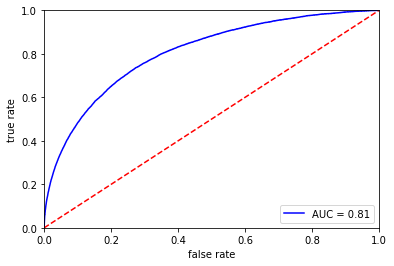

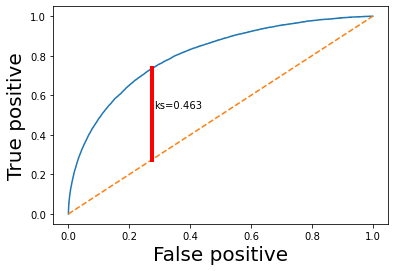

In [68]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split

y_pred = lgb.predict(X_dev[feacols2])

fpr, tpr, thresholds = roc_curve(y_dev, y_pred)

#计算ROC，并绘制曲线
rocauc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % rocauc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('true rate')
plt.xlabel('false rate')
plt.show()
    
ks_value = max(abs(fpr-tpr))
#ROC曲线
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle='--')
#绘制KS
x = np.argwhere(abs(fpr-tpr) == ks_value)[0, 0]
plt.plot([fpr[x], fpr[x]], [fpr[x], tpr[x]], linewidth=4, color='r')
plt.text(fpr[x]+0.01,tpr[x]-0.2, 'ks='+str(format(ks_value,'0.3f')),color= 'black')
plt.xlabel('False positive', fontsize=20)
plt.ylabel('True positive', fontsize=20)
plt.show()

In [72]:
# lgb.predict(X_dev[feacols2], raw_score=False), fpr[x]
y_pred01 = (y_pred >= fpr[x]) * 1
y_pred01


array([0, 0, 0, ..., 1, 0, 0])

In [75]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
confusion_matrix(y_dev, y_pred01)


array([[138360,   2964],
       [  9672,   2760]], dtype=int64)

#### save model..

In [76]:
import joblib
joblib.dump(lgb, "./lgb.pkl")

['./lgb.pkl']

### predict


In [77]:
test['TARGET'] = (lgb.predict(test[feacols2]) >= fpr[x]) * 1

D:\Users\jwangiy\AppData\Local\Temp/ipykernel_4788/2612185897.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['TARGET'] = (lgb.predict(test[feacols2]) >= fpr[x]) * 1


In [79]:
test[['SK_ID_CURR', 'TARGET']].to_csv("./submission.csv", index=False, sep=',')